# Educational Reading Level Classification

## Import Libraries

In [1]:
pip install transformers datasets evaluate accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.0 MB/s eta 0:00:00


In [2]:
import datasets, evaluate, accelerate
import random
import numpy as np
import pandas as pd
import torch
import transformers
from transformers import AutoTokenizer
from datasets import Dataset

## Load Data

In [3]:
# Load fiction and nonfiction data
all_fiction_data = pd.read_csv("data/fiction.csv")
all_nonfiction_data = pd.read_csv("data/nonfiction.csv")

In [4]:
# Shuffle data randomly
all_fiction_data = all_fiction_data.sample(frac=1)
all_nonfiction_data = all_nonfiction_data.sample(frac=1)

## Clean Data

In [5]:
# Rename columns for consistency
all_fiction_data = all_fiction_data.rename(columns={"passage": "text",
                                                    "reading_level": "labels"})

In [6]:
# Check unique classes
all_fiction_data['labels'].unique()

array(['Elementary', 'High', 'Middle ', 'Middle', 'High '], dtype=object)

In [7]:
# Combine classes that are the same
map_levels = {
    'Middle ': 'Middle',
    'High ': 'High'
}

all_fiction_data['labels'] = all_fiction_data['labels'].replace(map_levels)

In [8]:
# Check amount of data in each class
all_fiction_data['labels'].value_counts()

,count
labels,
Middle,1746
High,1741
Elementary,1661


In [9]:
# View data
all_fiction_data

,text,labels
207,"""I can't stand it, Momma!"" Brenda again. ""Make...",Elementary
3808,I didn’t have a literary agent then to explain...,High
4553,But remembering Edna’s whimsical turn of mind ...,High
1202,"“No, thanks.”",Elementary
498,Owl jumped up and down on top of his bed.,Elementary
...,...,...
1107,"Of course she was very pleased to be asked, bu...",Elementary
1072,"At first Mrs. Darling did not know, but after ...",Elementary
55,My father hid in the hold for six days and nig...,Elementary
4263,Let not the royal bed of Denmark be A couch fo...,High


In [10]:
# Convert to Hugging Face Dataset
all_fiction_data = Dataset.from_pandas(all_fiction_data)
all_nonfiction_data = Dataset.from_pandas(all_nonfiction_data)

## Prepare Data for Classification

In [11]:
id2label = {0: "Elementary", 1: "Middle", 2: "High"}
label2id = {"Elementary": 0, "Middle": 1, "High": 2}

In [12]:
all_fiction_data

Dataset({
    features: ['text', 'labels', '__index_level_0__'],
    num_rows: 5148
})

In [13]:
# Turn labels into 0, 1, or 2
def map_labels_to_number(example):
  example["labels"] = label2id[example["labels"]]
  return example

fiction_data = all_fiction_data.map(map_labels_to_number)

Map:   0%|          | 0/5148 [00:00<?, ? examples/s]

In [14]:
# Split data into training and test sets
fiction_data = fiction_data.train_test_split(test_size=0.2, seed=42)

In [15]:
fiction_data

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', '__index_level_0__'],
        num_rows: 4118
    })
    test: Dataset({
        features: ['text', 'labels', '__index_level_0__'],
        num_rows: 1030
    })
})

## Tokenize Data

In [16]:
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path="roberta-large",
                                          use_fast=True)

tokenizer

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

RobertaTokenizerFast(name_or_path='roberta-large', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}
)

In [17]:
def tokenize_text(examples):
    """
    Tokenize given example text and return the tokenized text.
    """
    return tokenizer(examples["text"],
                     padding=True,
                     truncation=True)

def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=256
    )

# different tokenizer for RoBERTa
tokenized_dataset = fiction_data.map(tokenize, batched=True)

Map:   0%|          | 0/4118 [00:00<?, ? examples/s]

Map:   0%|          | 0/1030 [00:00<?, ? examples/s]

In [18]:
# # Map tokenize_text function to the dataset
# tokenized_dataset = fiction_data.map(function=tokenize_text,
#                               batched=True,
#                               batch_size=1000)

# tokenized_dataset

In [19]:
# Get two samples from the tokenized dataset
train_tokenized_sample = tokenized_dataset["train"][0]
test_tokenized_sample = tokenized_dataset["test"][0]

for key in train_tokenized_sample.keys():
    print(f"[INFO] Key: {key}")
    print(f"Train sample: {train_tokenized_sample[key]}")
    print(f"Test sample: {test_tokenized_sample[key]}")
    print("")


[INFO] Key: text
Train sample: “Don’t neglect me,” entreated Madame Ratignolle; “and don’t mind what I said about Arobin, or having some one to stay with you.”
Test sample: Again, the rim ice broke away before and behind, and there was no escape except up the cliff. Perrault scaled it by a miracle, while François prayed for just that miracle; and with every thong and sled lashing and the last bit of harness rove into a long rope, the dogs were hoisted, one by one, to the cliff crest. François came up last, after the sled and load. Then came the search for a place to descend, which descent was ultimately made by the aid of the rope, and night found them back on the river with a quarter of a mile to the day’s credit.

[INFO] Key: labels
Train sample: 2
Test sample: 2

[INFO] Key: __index_level_0__
Train sample: 4552
Test sample: 3785

[INFO] Key: input_ids
Train sample: [0, 17, 48, 6766, 17, 27, 90, 13856, 162, 6, 17, 46, 3838, 34381, 38367, 12041, 4932, 1168, 459, 131, 44, 48, 463, 218,

## Set Up Evaluation Metric

In [20]:
import evaluate
import numpy as np
from typing import Tuple

In [21]:
accuracy_metric = evaluate.load("accuracy")

def compute_accuracy(predictions_and_labels: Tuple[np.array, np.array]):
  """
  Computes the accuracy of a model by comparing the predictions and labels.
  """
  predictions, labels = predictions_and_labels

  # Get highest prediction probability of each prediction if predictions are probabilities
  if len(predictions.shape) >= 2:
    predictions = np.argmax(predictions, axis=1)

  return accuracy_metric.compute(predictions=predictions, references=labels)


## Set Up Model for Training

In [22]:
from transformers import AutoModelForSequenceClassification

# Setup model for fine-tuning with classification head (top layers of network)
model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="roberta-large",
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
# Remove unnecessary columns
tokenized_dataset = tokenized_dataset.remove_columns(
    [col for col in tokenized_dataset["train"].column_names
     if col not in ["input_ids", "attention_mask", "labels"]]
)

In [24]:
def count_params(model):
    """
    Count the parameters of a PyTorch model.
    """
    trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_parameters = sum(p.numel() for p in model.parameters())

    return {"trainable_parameters": trainable_parameters, "total_parameters": total_parameters}

# Count # parameters of the model
count_params(model)

{'trainable_parameters': 355362819, 'total_parameters': 355362819}

All parameters in the model are trainable!

### Create Directory for Saving Models

In [25]:
# Create model output directory
from pathlib import Path

# Create models directory
models_dir = Path("models")
models_dir.mkdir(exist_ok=True)

# Create model save name
model_save_name = "reading_level_text_classifier-roberta-large"

# Create model save path
model_save_dir = Path(models_dir, model_save_name)

model_save_dir

PosixPath('models/reading_level_text_classifier-roberta-large')

### Set Up Training Arguments

In [26]:
from transformers import TrainingArguments, EarlyStoppingCallback

print(f"[INFO] Saving model checkpoints to: {model_save_dir}")

# Create training arguments
training_args = TrainingArguments(
    output_dir=model_save_dir,

    learning_rate=1e-5,
    weight_decay=0.05,
    warmup_ratio=0.1,

    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=1,
    num_train_epochs=3,

    fp16=True,

    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    load_best_model_at_end=True,

    no_cuda=False,

    logging_strategy="epoch",
    report_to="none",

    hub_private_repo=False,
)

[INFO] Saving model checkpoints to: models/reading_level_text_classifier-roberta-large


### Set Up Trainer Instance

In [27]:
import os
import torch
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
from transformers import Trainer

# Setup Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_accuracy
)

/tmp/ipython-input-1252012012.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## Training Text Classification Model

In [28]:
# Train a text classification model
results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.896500,0.782438,0.686408
2,0.580100,0.722195,0.812621
3,0.385800,0.934376,0.830097


## Save Model for Later Use

In [29]:
# Save model
print(f"[INFO] Saving model to {model_save_dir}")
trainer.save_model(output_dir=model_save_dir)

[INFO] Saving model to models/reading_level_text_classifier-roberta-large


## Inspect Model Training Metrics

In [30]:
# Get training history
trainer_history_all = trainer.state.log_history
trainer_history_metrics = trainer_history_all[:-1] # get everything except the training time metrics
trainer_history_training_time = trainer_history_all[-1] # same value as results.metrics from above

# View the first 4 metrics from the training history
trainer_history_metrics[:4]

[{'loss': 0.8965,
  'grad_norm': 8.054898262023926,
  'learning_rate': 7.411003236245955e-06,
  'epoch': 1.0,
  'step': 1030},
 {'eval_loss': 0.7824382185935974,
  'eval_accuracy': 0.6864077669902913,
  'eval_runtime': 12.502,
  'eval_samples_per_second': 82.387,
  'eval_steps_per_second': 20.637,
  'epoch': 1.0,
  'step': 1030},
 {'loss': 0.5801,
  'grad_norm': 3.4468588829040527,
  'learning_rate': 3.707299532542251e-06,
  'epoch': 2.0,
  'step': 2060},
 {'eval_loss': 0.7221946120262146,
  'eval_accuracy': 0.8126213592233009,
  'eval_runtime': 12.4779,
  'eval_samples_per_second': 82.546,
  'eval_steps_per_second': 20.677,
  'epoch': 2.0,
  'step': 2060}]

In [31]:
import pprint # import pretty print for nice printing of lists

# Extract training and evaluation metrics
trainer_history_training_set = []
trainer_history_eval_set = []

# Loop through metrics and filter for training and eval metrics
for item in trainer_history_metrics:
    item_keys = list(item.keys())
    # Check to see if "eval" is in the keys of the item
    if any("eval" in item for item in item_keys):
        trainer_history_eval_set.append(item)
    else:
        trainer_history_training_set.append(item)

# Show the first two items in each metric set
print(f"[INFO] First two items in training set:")
pprint.pprint(trainer_history_training_set[:2])

print(f"\n[INFO] First two items in evaluation set:")
pprint.pprint(trainer_history_eval_set[:2])

[INFO] First two items in training set:
[{'epoch': 1.0,
  'grad_norm': 8.054898262023926,
  'learning_rate': 7.411003236245955e-06,
  'loss': 0.8965,
  'step': 1030},
 {'epoch': 2.0,
  'grad_norm': 3.4468588829040527,
  'learning_rate': 3.707299532542251e-06,
  'loss': 0.5801,
  'step': 2060}]

[INFO] First two items in evaluation set:
[{'epoch': 1.0,
  'eval_accuracy': 0.6864077669902913,
  'eval_loss': 0.7824382185935974,
  'eval_runtime': 12.502,
  'eval_samples_per_second': 82.387,
  'eval_steps_per_second': 20.637,
  'step': 1030},
 {'epoch': 2.0,
  'eval_accuracy': 0.8126213592233009,
  'eval_loss': 0.7221946120262146,
  'eval_runtime': 12.4779,
  'eval_samples_per_second': 82.546,
  'eval_steps_per_second': 20.677,
  'step': 2060}]


In [32]:
# Create pandas DataFrames for the training and evaluation metrics
trainer_history_training_df = pd.DataFrame(trainer_history_training_set)
trainer_history_eval_df = pd.DataFrame(trainer_history_eval_set)

trainer_history_training_df
trainer_history_eval_df

,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,step
0,0.782438,0.686408,12.5020,82.387,20.637,1.0,1030
1,0.722195,0.812621,12.4779,82.546,20.677,2.0,2060
2,0.934376,0.830097,12.5256,82.231,20.598,3.0,3090


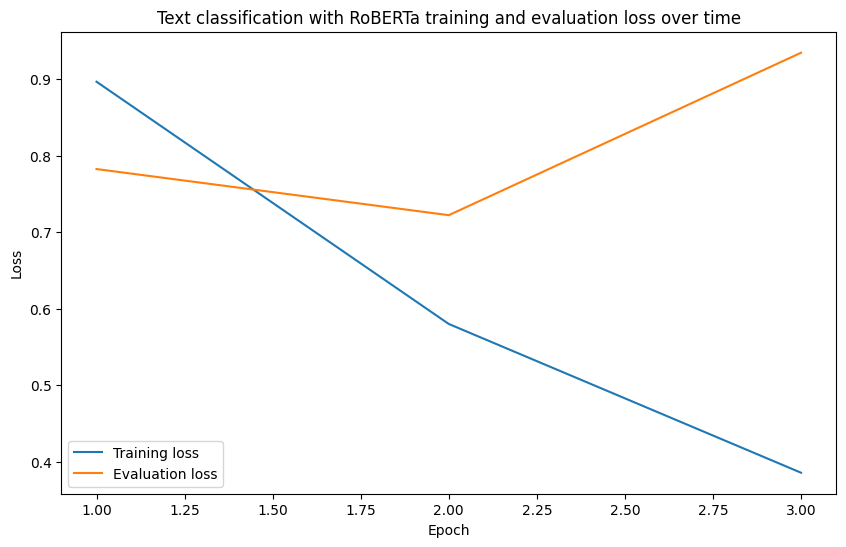

In [33]:
# Plot training and evaluation loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(trainer_history_training_df["epoch"], trainer_history_training_df["loss"], label="Training loss")
plt.plot(trainer_history_eval_df["epoch"], trainer_history_eval_df["eval_loss"], label="Evaluation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Text classification with RoBERTa training and evaluation loss over time")
plt.legend()
plt.show()

Looks like epoch=2 seems to produce the best model.

In [39]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model = AutoModelForSequenceClassification.from_pretrained("/content/models/reading_level_text_classifier-roberta-large/checkpoint-2060")
tokenizer = AutoTokenizer.from_pretrained("/content/models/reading_level_text_classifier-roberta-large/checkpoint-2060")

In [50]:
tokenized_test = fiction_data["test"].map(tokenize_text, batched=True)

results = trainer.evaluate(tokenized_test)
results.pop("epoch")

Map:   0%|          | 0/1030 [00:00<?, ? examples/s]

3.0

In [52]:
pd.DataFrame(results, index=[0])

,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,0.729701,0.812621,24.7405,41.632,10.428
